In [9]:
import numpy as np
import torch
from torch import nn
from torch import Tensor
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from climb_conversion import ClimbsFeatureArray

climbs = ClimbsFeatureArray()
dataset = climbs.get_classifier_dataset(limit=1000)
dataset[0]

Initializing ClimbsFeatureArray...
ClimbsFeatureArray initialized! 132057 unique climbs added!


(tensor([[ 0.0000,  0.0000,  0.1117, -0.5647, -0.4788, -0.9626,  0.4949,  0.1429],
         [-0.0870, -0.5405, -0.0031, -0.0611, -0.4788, -0.9626,  0.4949,  0.1429],
         [ 0.0000, -0.5405, -0.0031, -0.0611, -0.4788, -0.9626,  0.4949,  0.1429],
         [-0.1739, -0.2162,  0.0357,  0.0094, -0.4788, -0.9626,  0.4949,  0.1429],
         [-0.1304,  0.1622, -0.3267, -0.5005, -0.4788, -0.9626,  0.4949,  0.1429],
         [-0.0435,  0.2703, -0.0112, -0.4194, -0.4788, -0.9626,  0.4949,  0.1429],
         [ 0.1304,  0.4865,  0.2634, -0.5250, -0.4788, -0.9626,  0.4949,  0.1429],
         [ 0.0000,  0.6486, -0.2856, -0.8135, -0.4788, -0.9626,  0.4949,  0.1429],
         [ 0.3913,  0.2703, -0.5112, -0.3729, -0.4788, -0.9626,  0.4949,  0.1429],
         [ 0.0435,  0.8108,  0.2071, -0.8304, -0.4788, -0.9626,  0.4949,  0.1429],
         [ 0.0000,  0.8649,  0.0413, -0.8501, -0.4788, -0.9626,  0.4949,  0.1429],
         [ 0.1304,  1.1351,  0.5235, -0.7133, -0.4788, -0.9626,  0.4949,  0.1429],
    

In [ ]:
#-----------------------------------------------------------------------
# DATA BATCHING AND PREPROCESSING
#-----------------------------------------------------------------------
from torch.nn.utils.rnn import pack_padded_sequence, PackedSequence
from tqdm import tqdm
import matplotlib.pyplot as plt


def sort_by_length(batch):
    """Collate function for preparing to Pack-sort the tensors, by sorting them in order from longest to shortest."""
    sorted_batch = sorted(batch, key=lambda b: b[2], reverse=True)
    x, y, l = zip(*sorted_batch)
    return (
        torch.stack(x),
        torch.stack(y),
        torch.tensor(l)
    )

def train_lstm_on_packed_dataset(model: nn.Module, dataset: TensorDataset, epochs: int = 100, lr=1e-3, save_path: str | None = None):
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    train_loader = DataLoader(dataset=dataset, batch_size=64, shuffle=True, collate_fn=sort_by_length)
    losses = []
    with tqdm(range(epochs)) as pbar:
        for epoch in pbar:
            epoch_losses = []
            for (idx, (x, y, lengths)) in enumerate(train_loader):
                packed_input = pack_padded_sequence(
                    input = x,
                    lengths = lengths,
                    batch_first = True,
                    enforce_sorted = True
                )
                pred_logits = model(packed_input)
                loss = model.loss(pred_logits, y)
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())
            mean_loss = sum(epoch_losses)/len(epoch_losses)
            losses.append(mean_loss)
            pbar.set_postfix_str(f"Epoch: {epoch}, Mean Loss: {mean_loss}, Min Loss: {min(losses)}, Batches{len(epoch_losses)}")
    
    if save_path:
        torch.save(model.state_dict(), save_path)
    
    fig, ax = plt.subplots()

    ax.plot(list(range(len(losses))), losses)
    ax.set_yscale('log')
    ax.set_title(f'Mean Batch-Loss per Epoch, LSTM Hold Classifier ({sum([p.numel() for p in model.parameters()])} params)')
    plt.show()

c:\Users\EvanM\anaconda3\envs\torch-cpu\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn(
100%|██████████| 100/100 [01:39<00:00,  1.01it/s, Epoch: 99, Mean Loss: 0.10778163559734821, Min Loss: 0.09678808017633855]


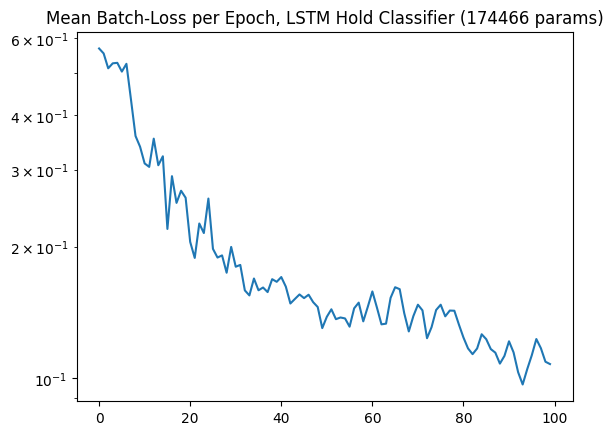

In [ ]:
#-----------------------------------------------------------------------
# HOLD ROLE CLASSIFICATION
#-----------------------------------------------------------------------

class HoldClassifier(nn.Module):
    def __init__(self, input_dim: int = 8, hidden_dim: int = 256, num_layers: int = 1):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            dropout = 0.3,
            bidirectional=True
        )

        self.classification_head = nn.Sequential(
            nn.Linear(hidden_dim*2, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 2)
        )

        self.loss_func = nn.BCEWithLogitsLoss()
    
    def loss(self, pred_roles: Tensor, true_roles: Tensor):
        """Get the loss from the model's predictions, via cross-entropy loss."""
        return self.loss_func(pred_roles, true_roles)

    
    def forward(self, holds_cond: PackedSequence)-> Tensor:
        """Run the forward pass. Predicts the roles for a given (possibly batched) set of holds, given (possibly batched) wall conditions."""

        _, (hs, cs) = self.lstm(holds_cond)

        lstm_final_state = torch.cat([hs[-1],hs[-2]], dim=1)

        sf_logits = self.classification_head(lstm_final_state)

        return sf_logits

lstm_hold_classifer = HoldClassifier()
train_lstm_on_packed_dataset(
    model = lstm_hold_classifer,
    dataset = dataset,
    epochs=1,
    save_path='data/weights/lstm-hold-classifier.pth'
)